In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


In [16]:

file_path = "C:/Users/ADMIN/Downloads/imdb_kaggle.csv"   

try:
    df = pd.read_csv(file_path)
    print("Loaded:", file_path)
except Exception as e:
    print(f"Error loading {file_path}: {e}")
    raise

print("Shape:", df.shape)
display(df.head())
print("\nData types & non-null counts:")
display(df.info())
print("\nTop missing-value counts:")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Loaded: C:/Users/ADMIN/Downloads/imdb_kaggle.csv
Shape: (1000, 9)


,rank,year,duration,age_limit,rating,numberof_ratings,Metascore,description,name
0,1,1994,2h 22m,15,9.3,(2.9M),82.0,"Over the course of several years, two convicts...",The Shawshank Redemption
1,2,1972,2h 55m,15,9.2,(2M),100.0,The aging patriarch of an organized crime dyna...,The Godfather
2,3,2008,2h 32m,12A,9.0,(2.9M),84.0,When the menace known as the Joker wreaks havo...,The Dark Knight
3,4,2003,3h 21m,12A,9.0,(2M),94.0,Gandalf and Aragorn lead the World of Men agai...,The Lord of the Rings: The Return of the King
4,5,1993,3h 15m,15,9.0,(1.5M),95.0,"In German-occupied Poland during World War II,...",Schindler's List



Data types & non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rank              1000 non-null   int64  
 1   year              1000 non-null   int64  
 2   duration          1000 non-null   object 
 3   age_limit         997 non-null    object 
 4   rating            1000 non-null   float64
 5   numberof_ratings  1000 non-null   object 
 6   Metascore         842 non-null    float64
 7   description       1000 non-null   object 
 8   name              1000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 70.4+ KB


None


Top missing-value counts:


Metascore           158
age_limit             3
rank                  0
duration              0
year                  0
rating                0
numberof_ratings      0
description           0
name                  0
dtype: int64

In [21]:

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

rating_candidates = ['rating','ratings','score','avg_vote','imdb_rating','rating_value','user_rating']
title_candidates  = ['title','name','movie','movie_title','original_title']
age_limit_candidates  = ['age_limit','age_limit','listed_in']
year_candidates   = ['year','release_year','title_year','year_of_release']

def find_column(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

rating_col = find_column(rating_candidates)
title_col  = find_column(title_candidates)
age_limit_col  = find_column(age_limit_candidates)
year_col   = find_column(year_candidates)

print("Detected columns (None means not found):")
print("rating_col:", rating_col)
print("title_col: ", title_col)
print("age_limit: ", age_limit_col)
print("year_col:  ", year_col)


Detected columns (None means not found):
rating_col: rating
title_col:  name
age_limit:  age_limit
year_col:   year


In [22]:

df = df.drop_duplicates()


for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

if rating_col:
    df[rating_col] = pd.to_numeric(df[rating_col], errors='coerce')

print("After basic cleaning. Shape:", df.shape)
if rating_col:
    print("Missing ratings:", df[rating_col].isnull().sum(), "out of", len(df))


After basic cleaning. Shape: (1000, 9)
Missing ratings: 0 out of 1000


In [23]:

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if numeric_cols:
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

for col in categorical_cols:
    if df[col].isnull().any():
        try:
            df[col] = df[col].fillna(df[col].mode().iloc[0])
        except:
            df[col] = df[col].fillna('Unknown')

print("Missing values after fill (top):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Missing values after fill (top):


rank                0
year                0
duration            0
age_limit           0
rating              0
numberof_ratings    0
metascore           0
description         0
name                0
dtype: int64

In [25]:

if age_limit_col:
    def extract_primary_age_limit(x):
        if pd.isna(x): return np.nan
        if isinstance(x, (list,tuple,set)):
            return list(x)[0] if len(x)>0 else np.nan
        s = str(x)
        for sep in ['|', ',', ';', '/']:
            if sep in s:
                return s.split(sep)[0].strip()
        return s.strip()

    df['primary_age_limit'] = df[age_limit_col].apply(extract_primary_age_limit)
    print("Created column: primary_age_limit(examples):")
    display(df[['primary_age_limit']].dropna().head(10))
else:
    print("No age_limit column detected; skipping age_limit normalization.")


Created column: primary_age_limit(examples):


,primary_age_limit
0,15
1,15
2,12A
3,12A
4,15
5,U
6,X
7,PG
8,18
9,12A


In [26]:

if rating_col:
    print("Overall rating statistics:")
    display(df[rating_col].describe())
    print("Mean:", df[rating_col].mean())
    print("Median:", df[rating_col].median())
    try:
        print("Mode:", df[rating_col].mode().iloc[0])
    except:
        print("Mode: n/a")
else:
    print("Rating column not detected; cannot compute summary statistics.")


Overall rating statistics:


count    1000.000000
mean        7.972800
std         0.273633
min         7.600000
25%         7.800000
50%         7.900000
75%         8.100000
max         9.300000
Name: rating, dtype: float64

Mean: 7.972799999999999
Median: 7.9
Mode: 7.7


In [27]:
# Cell 8: Grouped statistics by primary_genre
if 'primary_age_limit' in df.columns and rating_col:
    age_limit_stats = df.groupby('primary_age_limit')[rating_col].agg(['count','mean','median','std']).sort_values('count', ascending=False)
    print("Genre statistics (count, mean, median, std):")
    display(age_limit_stats)
else:
    print("age_limit_genre or rating column missing; skipping grouped stats.")


Genre statistics (count, mean, median, std):


,count,mean,median,std
primary_age_limit,,,,
15,289,7.934256,7.90,0.277832
PG,238,7.986555,8.00,0.232551
12A,138,8.000000,7.90,0.309933
18,108,7.987963,7.90,0.308059
U,78,8.023077,8.00,0.286911
X,50,7.972000,8.00,0.277040
12,28,7.935714,7.85,0.306974
A,26,7.973077,8.00,0.188802
AA,22,7.931818,7.95,0.178316


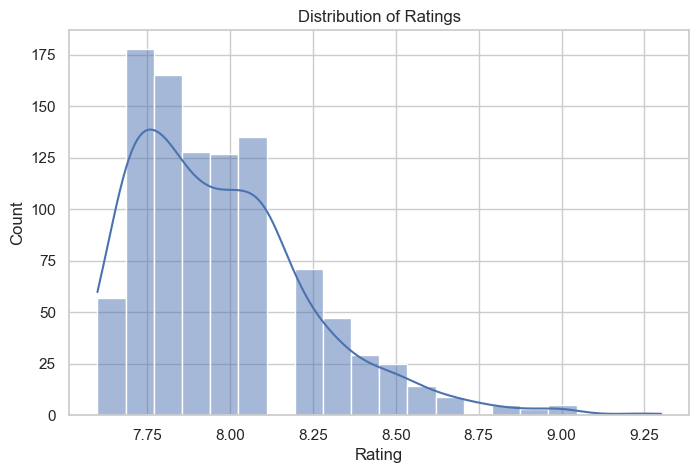

In [28]:

if rating_col:
    plt.figure(figsize=(8,5))
    sns.histplot(df[rating_col].dropna(), bins=20, kde=True)
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()
else:
    print("No rating column for histogram.")

if 'age_limit_genre' in df.columns and rating_col:
    plt.figure(figsize=(12,6))

    order = df.groupby('age_limit_genre')[rating_col].median().sort_values(ascending=False).index
    sns.boxplot(x='age_limit_genre', y=rating_col, data=df, order=order)
    plt.title('Ratings by age_limit Genre')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.show()


In [29]:

if title_col and rating_col:
    top_n = 10
    top_movies = df.sort_values(by=rating_col, ascending=False).head(top_n)
    print(f"Top {top_n} movies by {rating_col}:")
    display(top_movies[[title_col, rating_col] + (['age_limit_genre'] if 'age_limit_genre' in df.columns else [])])
else:
    print("Missing title or rating column; cannot list top movies.")

if 'age_limit_genre' in df.columns and title_col and rating_col:
   
    idx = df.groupby('age_limit_genre')[rating_col].idxmax()
    top_per_age_limit = df.loc[idx].sort_values(by=rating_col, ascending=False)
    print("Top movie per age_limit_genre:")
    display(top_per_age_limit[['age_limit_genre', title_col, rating_col]])


Top 10 movies by rating:


,name,rating
0,The Shawshank Redemption,9.3
1,The Godfather,9.2
2,The Dark Knight,9.0
3,The Lord of the Rings: The Return of the King,9.0
4,Schindler's List,9.0
6,The Godfather Part II,9.0
5,12 Angry Men,9.0
8,Pulp Fiction,8.9
7,The Lord of the Rings: The Fellowship of the Ring,8.9
9,12th Fail,8.9


In [33]:

if 'age_limit_genre' in df.columns:
    plt.figure(figsize=(10,5))
    df['age_limit_genre'].value_counts().plot(kind='bar')
    plt.title('Number of movies by age_limit genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    if rating_col:
        plt.figure(figsize=(10,6))
        df.groupby('age_limit_genre')[rating_col].mean().sort_values().plot(kind='barh')
        plt.title('Average rating by age_limit genre')
        plt.xlabel('Average rating')
        plt.show()
else:
    print("No age_limit_genre column for genre charts.")


No age_limit_genre column for genre charts.


In [31]:

df.to_csv("movies_cleaned_for_dashboard.csv", index=False)
print("Saved: movies_cleaned_for_dashboard.csv")

if 'genre_stats' in locals():
    genre_stats.to_csv("genre_stats.csv")
    print("Saved: genre_stats.csv")

if 'top_movies' in locals():
    top_movies.to_csv("top_movies.csv", index=False)
    print("Saved: top_movies.csv")

print("Files saved in current notebook directory.")


Saved: movies_cleaned_for_dashboard.csv
Saved: top_movies.csv
Files saved in current notebook directory.


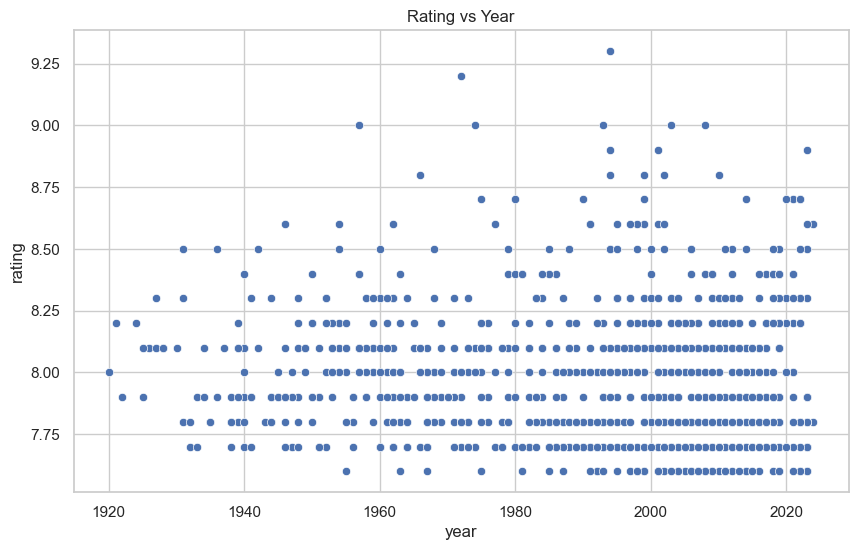

In [32]:

if year_col and rating_col:
    plt.figure(figsize=(10,6))
   
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    sns.scatterplot(data=df, x=year_col, y=rating_col)
    plt.title('Rating vs Year')
    plt.show()
else:
    print("Year or rating column missing; skipping rating vs year plot.")


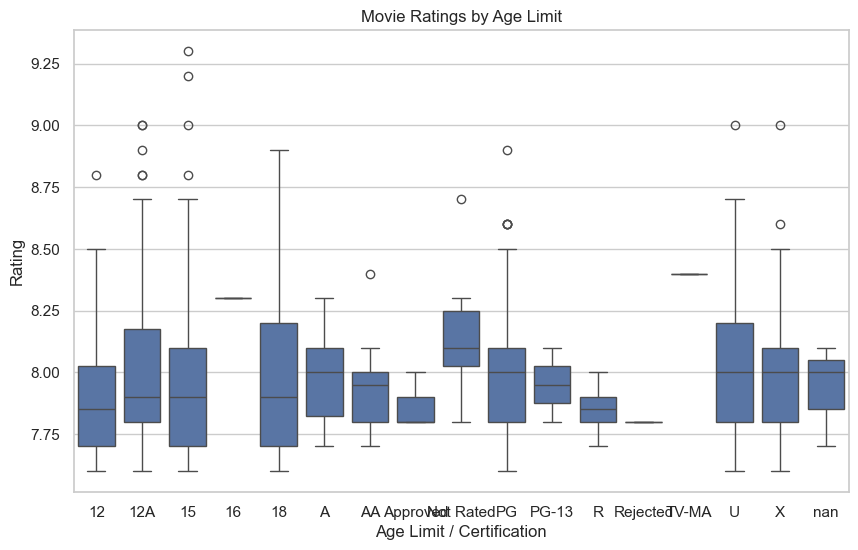

In [34]:

age_candidates = ['age_limit', 'certificate', 'content_rating', 'rating_certificate']
age_col = None
for c in age_candidates:
    if c in df.columns:
        age_col = c
        break

if age_col and rating_col:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=age_col, y=rating_col, data=df, order=sorted(df[age_col].dropna().unique()))
    plt.title('Movie Ratings by Age Limit')
    plt.xlabel('Age Limit / Certification')
    plt.ylabel('Rating')
    plt.show()
else:
    print("No age limit or certification column found in dataset.")


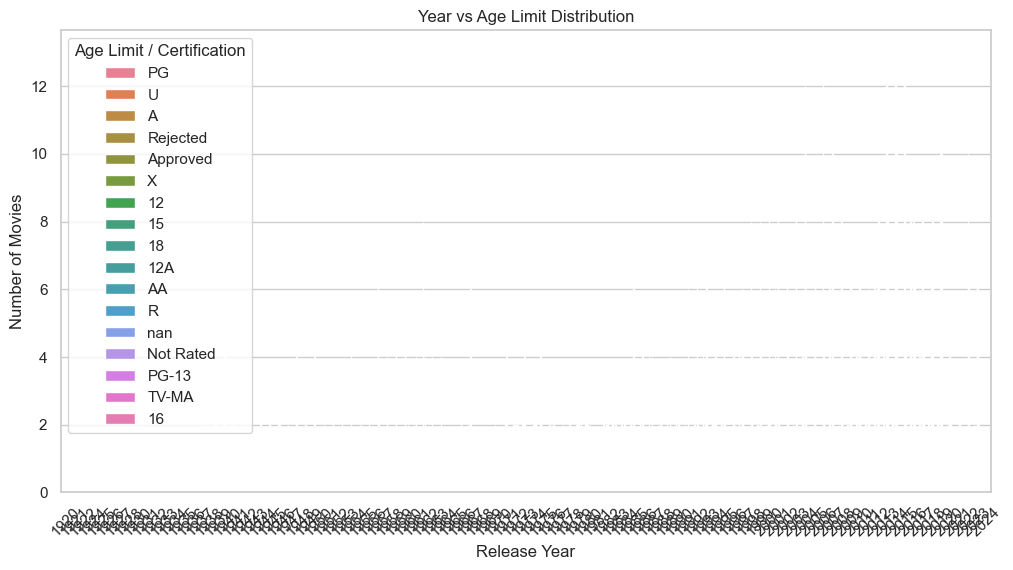

In [36]:

year_candidates = ['year', 'release_year', 'title_year', 'year_of_release']
year_col = None
for c in year_candidates:
    if c in df.columns:
        year_col = c
        break

age_candidates = ['age_limit', 'certificate', 'content_rating', 'rating_certificate']
age_col = None
for c in age_candidates:
    if c in df.columns:
        age_col = c
        break

if year_col and age_col:
    
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    
    df_filtered = df.dropna(subset=[year_col, age_col])
    
    plt.figure(figsize=(12,6))
    sns.countplot(x=year_col, hue=age_col, data=df_filtered, order=sorted(df_filtered[year_col].unique()))
    plt.title('Year vs Age Limit Distribution')
    plt.xlabel('Release Year')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45)
    plt.legend(title='Age Limit / Certification')
    plt.show()
else:
    print("Year or age limit column not found in dataset.")


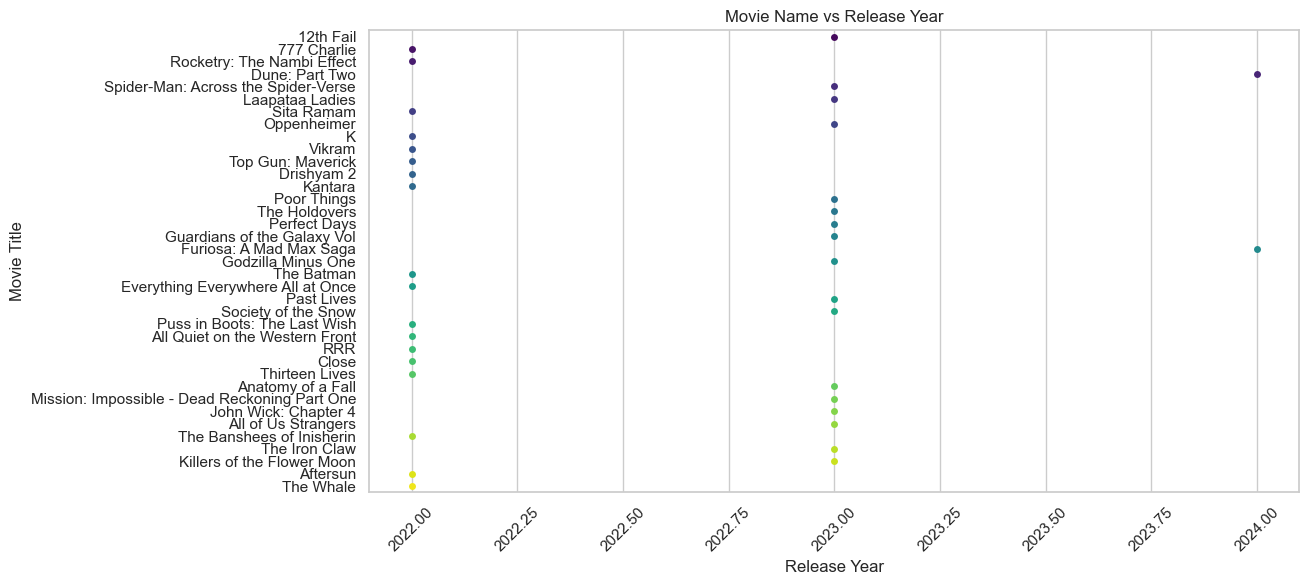

In [37]:

title_candidates = ['title', 'name', 'movie', 'movie_title', 'original_title']
year_candidates = ['year', 'release_year', 'title_year', 'year_of_release']

title_col = None
year_col = None

for c in title_candidates:
    if c in df.columns:
        title_col = c
        break

for c in year_candidates:
    if c in df.columns:
        year_col = c
        break

if title_col and year_col:
    
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    df_filtered = df.dropna(subset=[year_col, title_col])

    top_n = 30  
    recent_years = df_filtered[year_col].nlargest(top_n).unique()

    df_plot = df_filtered[df_filtered[year_col].isin(recent_years)]

    plt.figure(figsize=(12,6))
    sns.stripplot(x=year_col, y=title_col, data=df_plot, jitter=True, palette="viridis")
    plt.title('Movie Name vs Release Year')
    plt.xlabel('Release Year')
    plt.ylabel('Movie Title')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Title or year column not found in dataset.")


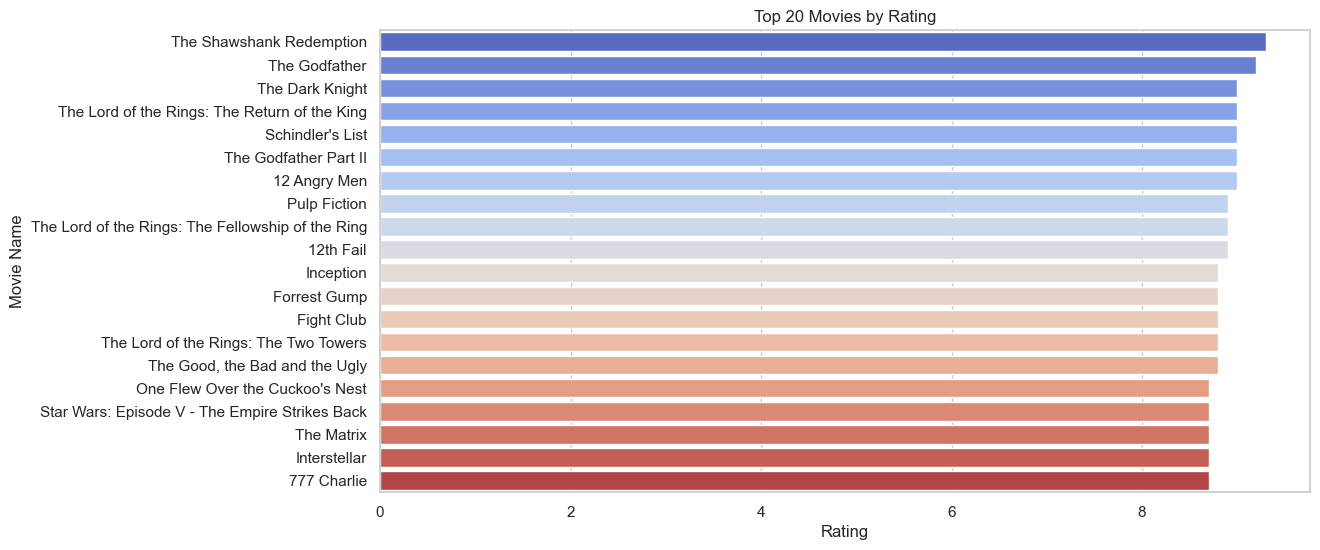

In [39]:

title_candidates = ['title', 'name', 'movie', 'movie_title', 'original_title']
rating_candidates = ['rating','ratings','score','avg_vote','imdb_rating','rating_value','user_rating']

title_col = None
rating_col = None

for c in title_candidates:
    if c in df.columns:
        title_col = c
        break

for c in rating_candidates:
    if c in df.columns:
        rating_col = c
        break

if title_col and rating_col:
   
    df_filtered = df.dropna(subset=[title_col, rating_col])
    
    
    df_sorted = df_filtered.sort_values(by=rating_col, ascending=False)
    
   
    top_n = 20
    df_top = df_sorted.head(top_n)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=rating_col, y=title_col, data=df_top, palette="coolwarm")
    plt.title(f"Top {top_n} Movies by Rating")
    plt.xlabel("Rating")
    plt.ylabel("Movie Name")
    plt.show()
else:
    print("Title or rating column not found in dataset.")
